Generate GLCM features and train a SVM with them

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import multiprocessing
import sys
from sklearn import svm, metrics, decomposition, preprocessing, compose, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from joblib import Parallel, delayed
from scipy import stats

sys.path.append('/home/simon/Code/MasterThesis/project/include')
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
import utils as utl
import features as ft

%load_ext autoreload
%autoreload 2

BASE_DATA_PATH = '/data/simon/ownCloud/Data/'
NUM_HARALICK_FEATURES = 84

print(f'INFO> Using python version {sys.version_info}')
print(f'INFO> Using opencv version {cv2.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO> Using python version sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
INFO> Using opencv version 3.4.2


UTIL> Loading picture /data/simon/ownCloud/Data/QA Dataset/E006L.png


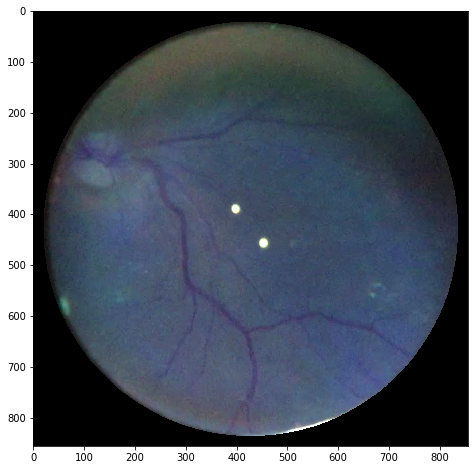

In [41]:
image = utl.load_image(BASE_DATA_PATH + 'QA Dataset/E006L.png')
image_enhanced = utl.enhance_contrast_image(image, clip_limit=3.5, tile_size=12)
mask, circle = utl.get_retina_mask(image_enhanced)
image = utl.crop_to_circle(cv2.bitwise_and(image, mask), circle)
plt.imshow(image)

## Dataset Preperation and Feature Extraction

In [42]:
#properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
print(ft.extract_feature_vector(image).shape)

def create_train_data(pos_path, neg_path):
    files_pos = [os.path.join(pos_path, p) for p in os.listdir(pos_path)]
    files_neg = [os.path.join(neg_path, p) for p in os.listdir(neg_path)]
    print(f'Reading {len(files_pos)}|{len(files_neg)} from {pos_path}|{neg_path} into dataset')
    
    files_pos = [f for f in files_pos if os.stat(f).st_size > 0 and os.path.isfile(f)]  # removes empty images in image list
    files_neg = [f for f in files_neg if os.stat(f).st_size > 0 and os.path.isfile(f)]
    #files_neg = [files_neg[i] for i in range(0, len(files_neg), 2)]
    
    y = np.zeros(len(files_pos) + len(files_neg))
    y[:len(files_pos)] = 1
    
    num_cpus = multiprocessing.cpu_count()
    x = Parallel(n_jobs=num_cpus)(delayed(cv2.imread)(f) for f in files_pos)
    x.extend(Parallel(n_jobs=num_cpus)(delayed(cv2.imread)(f) for f in files_neg))
    
    return x, y

FEAT> Length haralick features 84, Length histogram features 72
(156,)


In [43]:
train_pos_path = os.path.join(BASE_DATA_PATH, 'Frame Dataset/', 'pos')
train_neg_path = os.path.join(BASE_DATA_PATH, 'Frame Dataset/', 'neg')
x, y = create_train_data(train_pos_path, train_neg_path)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True) # 85% training and 15% test
#X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

feature_transformer = ft.FeatureExtractor(haralick_dist=3, clip_limit=4, hist_size=[8, 3, 3])
X_train = feature_transformer.transform(X_train)
X_test = feature_transformer.transform(X_test)

print("Training features: {}".format(X_train.shape))
print("Training labels: {}".format(y_train.shape))
print("Test features: {}".format(X_test.shape))
print("Test labels: {}".format(y_test.shape))

Reading 534|912 from /data/simon/ownCloud/Data/Frame Dataset/pos|/data/simon/ownCloud/Data/Frame Dataset/neg into dataset
Training features: (1227, 156)
Training labels: (1227,)
Test features: (217, 156)
Test labels: (217,)


In [44]:
#pca = decomposition.PCA(n_components=0.99)
cl_weights = 'balanced'#{0: 1, 1: 1.5}
column_transformer = compose.ColumnTransformer(
    [("haralick", preprocessing.MinMaxScaler(feature_range=(0, 1)), list(range(NUM_HARALICK_FEATURES))),
     ("histogram", preprocessing.MinMaxScaler(feature_range=(0, 1)), list(range(NUM_HARALICK_FEATURES, X_train[0].shape[0])))])
steps = [('transform', column_transformer), ('SVM', svm.SVC(cache_size=1000, probability=False, class_weight=cl_weights))]
pipeline = pipeline.Pipeline(steps)

## Training SVM Classifier (Grid search)

In [51]:
#%time
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-3, 2, 6)
params = {'SVM__C': C_range, 'SVM__gamma': gamma_range, 'SVM__kernel': ['rbf', 'linear'], #'features__haralick_dist': [1, 2, 4],
           'transform__histogram__feature_range': [(0, i) for i in np.arange(.1, 1., 0.2)]}
#params_dist = {'SVM__C': stats.logser(10e5), 'SVM__gamma': stats.logser(10e2), 'SVM__kernel': ['rbf'], 'transform__histogram__feature_range': stats.randint(.1, 1)}

fcustom_scorer = metrics.make_scorer(metrics.fbeta_score, beta=1.125)
gsc = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring=fcustom_scorer, verbose=1, n_jobs=-1)
#gsc = RandomizedSearchCV(estimator=pipeline, param_distributions=params_dist, cv=5, scoring='precision', verbose=10, n_jobs=-1, n_iter=500)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

print(f'SVM using best parameters: {best_params}')

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
SVM using best parameters: {'SVM__C': 100.0, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf', 'transform__histogram__feature_range': (0, 0.7000000000000001)}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   53.4s finished
/home/simon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [52]:
y_pred = gsc.predict(X_test)
#y_prob = best_svc.predict_proba(X_test)
#y_prob = np.amax(y_prob, axis=1)
print(f'SVM Prediction: {y_pred}, ground truth: {y_test}')
#print(f'SVM Prediction Probability: {np.where(y_prob < 0.8, 0, 1)}')

print("F1: ", metrics.f1_score(y_test, y_pred))
print("ROC AUC: ",  metrics.roc_auc_score(y_test, y_pred))
print("Matthews Corrcoef.: ", metrics.matthews_corrcoef(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("CM: ", metrics.confusion_matrix(y_test, y_pred))

SVM Prediction: [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1.], ground truth: [1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0.

## Results SVM / Save model
### linear SVM, standard scaler, C=1000, 90/10
- Precision:  0.9166666666666666
- Recall:  0.9506172839506173
- F1:  0.9333333333333332

### linear SVM, min/max scaler, C=1000, 90/10
- Precision:  0.9390243902439024
- Recall:  0.9625
- F1:  0.9506172839506174

### linear SVM, min/max scaler, C=1000, augmented with additional images, 90/10
- Precision:  0.9540229885057471
- Recall:  0.9431818181818182
- F1:  0.9485714285714286

### linear SVM, min/max scaler, C=1000, augmented, sample weights, 90/10
- Precision:  0.9879518072289156
- Recall:  0.9318181818181818
- F1:  0.9590643274853801

### Kernel SVM rbf, min/max scaler, C=100000, augmented, 90/10
- Precision:  0.9642857142857143
- Recall:  0.9204545454545454
- F1:  0.941860465116279

### Kernel SVM rbf, min/max scaler, C=100000, augmented, 85/15
- Precision:  0.9747899159663865
- Recall:  0.9508196721311475
- F1:  0.9626556016597511

### Linear SVM, min/max scaler, C=100, augmented 85/15, histogram features(weight=0.1)
- Precision:  0.9818181818181818
- Recall:  0.907563025210084
- F1:  0.9432314410480349

In [53]:
from joblib import dump
dump(gsc, os.path.join(BASE_DATA_PATH, 'pipeline_v3.joblib'))
#dump(best_svc, 'SVM_v2.joblib')
#dump(ct, 'transformer.joblib')

['/data/simon/ownCloud/Data/pipeline_v3.joblib']